In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import re
import os
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import pickle
from huggingface_hub import HfApi, hf_hub_download

2025-02-24 13:47:43.232853: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-24 13:47:43.263623: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-24 13:47:43.264160: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-24 13:47:44.106575: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/josh/.local/lib/python3.8/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Modeling

## Define Tensorflow Model

$$
\begin{matrix}
\text{Input 1: text}, X_1 & \rightarrow & \text{embed}: E(X_1) & \rightarrow & N_1(E(X_1)) \\
& & & & \searrow \\
& & & & & \oplus \rightarrow N_3 \bigg(\underbrace{N_1(E(X_1))}_\text{text}, \underbrace{N_2(X_2)}_\text{func rating} \bigg) \\
& & & & \nearrow \\
& & \text{Input 2: function rating}, X_2 & \rightarrow & N_2(X_2) \\
\end{matrix}
$$

In [2]:
# Define function to create the neural network model
def create_nn_model(embedding_dim: int, num_of_dense: int) -> Model:
    """
    Creates a neural network model that processes embedded user prompts using dense layers,
    concatenates it with function ratings, and passes through dense layers.

    Args:
        embedding_dim (int): Dimensionality of the embedding layer.
        num_of_dense (int): Number of dense layers before concatenation.

    Returns:
        Model: A compiled TensorFlow model.
    """
    # Text input - embedded vectors of specified embedding dimension
    text_input = Input(shape = (embedding_dim,), name = 'embedded_text_input')
    x = text_input

    # Dense layers for embedded text input
    # Start with enough neurons to have roughly embedding_dim^(1.5) squared neurons in initial layer
    # Restrict to 2 ** 12 = 4,096 neurons max for initial layer to keep model complexity
    # low enough for quick training and to use on small training datasets
    max_neurons = 2 ** min(np.round(np.log2(embedding_dim) * 1.5), 12)    
    
    # For every 2 layers, halve the number of neurons
    # This lets the model be very flexible for early layers and slowly become less flexible
    # This keeps the training relatively stochastic, which is helpful with low amounts of training data
    # If a layer has very few neurons, the model tends to plateau
    for i, _ in enumerate(range(num_of_dense)):
        # First layer uses max neurons, then halve the number of neurons every 2 layers
        divisor = 2 ** ((i + 1) // 2)
        num_neurons = max(1, int(max_neurons / divisor)) # Ensure integer neurons, minimum of 1
        x = Dense(num_neurons, activation = 'relu')(x)

    # Numeric input (func_rating) - one-hot encoded vector
    func_rating_input = Input(shape = (6,), name = 'func_rating_input')
    
    # Give some complexity to the function rating, but keep it simple with only one layer
    y = Dense(64, activation = 'relu')(func_rating_input)

    # Concatenate both paths, output is a classification task with 6 outputs
    concatenated = Concatenate()([x, y])
    output = Dense(6, activation = 'softmax', name = 'output')(concatenated)

    # Define and compile the model
    model = Model(inputs = [text_input, func_rating_input], outputs = output)
    model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return model

## Load Data and Preprocess

In [3]:
# Read in data from csv
df = pd.read_csv('prompts_and_ratings.csv')

# Drop urls as we will not be using them
df = df.drop(['url_to_check'], axis = 1)
    
# Preprocess prompts by replacing special characters with spaces
# Then, remove extra spaces, strip leading and trailing whitespace characters, and convert to lowercase
# This normalizes the prompts to prepare for vector embedding
df['user_prompt'] = [re.sub('\s+', ' ', re.sub('[^\w\s]', ' ', p)).strip().lower() for p in df['user_prompt']]
df

,user_prompt,func_rating,custom_rating
0,i have just been on an international flight ca...,2,3
1,what are the benefits of a vegetarian diet,2,4
2,what are the benefits of a vegetarian diet,2,2
3,what are the benefits of a vegetarian diet,2,3
4,how to improve mental health during stressful ...,3,3
...,...,...,...
297,how does altitude training affect endurance in...,3,3
298,what are the safest travel destinations for so...,3,2
299,how can travelers find sustainable and eco fri...,3,3
300,what cultural experiences should not be missed...,2,4


SentenceTransformers are designed to extract semantic meanings from whole sentences. Since each of the prompts should be evaluated as a whole rather than word by word, it makes more sense to transform them using SentenceTransformers rather using a bag-of-words or TF-IDF model. The SentenceTransformers from HuggingFace are pre-trained for these kinds of tasks.

The all-MiniLM-L6-v2 model was selected for the low dimensional outputs it produces. The normal model outputs 384 dimensional vectors, and when using binary precision (https://sbert.net/examples/applications/embedding-quantization/README.html#binary-quantization-in-sentence-transformers), the output is merely 48 dimensions. The amount of data available to train is quite small (~242 training samples with a 20% validation split), so the dimensionality needs to be low in order for the model to see any semblance of success while training.

In [4]:
# Create sentence embeddings, using all-MiniLM-L6-v2 model
# Use binary precision to reduce dimensionality, producing 48 dimension vectors
tokenizer = SentenceTransformer('all-MiniLM-L6-v2')
X_text = np.array([tokenizer.encode(p, precision = 'binary') for p in df['user_prompt']])

This model will be treated as a classification task, requiring the function and human ratings to be one-hot encoded.

In [5]:
# Check unique values for ratings to determine number of categories
print(
    f'Unique function ratings: {sorted(df.func_rating.unique())}',
    f'Unique human ratings: {sorted(df.custom_rating.unique())}',
    sep = '\n'
)

Unique function ratings: [0, 1, 2, 3, 4, 5]
Unique human ratings: [0, 1, 2, 3, 4, 5]


In [6]:
# Convert ratings to one-hot categorical arrays, use 6 categories based on data
num_categories = max(len(df.func_rating.unique()), len(df.custom_rating.unique()))
X_rating = tf.keras.utils.to_categorical(np.array(df['func_rating']).reshape(-1, 1), num_categories)
y = tf.keras.utils.to_categorical(np.array(df['custom_rating']).reshape(-1, 1), num_categories)

In [7]:
# Check the shapes of each input
print(f'X_text shape: {X_text.shape}')
print(f'X_ratings shape: {X_rating.shape}')
print(f'y shape: {y.shape}')

X_text shape: (302, 48)
X_ratings shape: (302, 6)
y shape: (302, 6)


## Instantiate Model

In [8]:
# Embedding dimension is decided based on preprocessing
embedding_dim = X_text.shape[1]

# The number of dense layers is a tuneable hyperparamter
# If there are too many dense layers, the model heavily overfits and takes a long time to train
# If there are too few, the model underfits
# After testing, 4 layers appears to be the happy medium in terms of model performance and training time
num_of_dense_layers = 4

# Create the model
model = create_nn_model(embedding_dim, num_of_dense_layers)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embedded_text_input (Input  [(None, 48)]                 0         []                            
 Layer)                                                                                           
                                                                                                  
 dense (Dense)               (None, 256)                  12544     ['embedded_text_input[0][0]'] 
                                                                                                  
 dense_1 (Dense)             (None, 128)                  32896     ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 128)                  16512     ['dense_1[0][0]']         

## Training

In [3]:
# Define and create a checkpoint directory
checkpoint_dir = './checkpoint'
os.makedirs(checkpoint_dir, exist_ok = True)
    
# Save epochs while training, to manually select best model later
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = os.path.join(checkpoint_dir, 'best_model-epoch_{epoch:02d}.h5'),
    save_freq = 'epoch'
)

In [10]:
# Train the model using a batch size of 2 and a 20% validation split for 80 epochs
model.fit(
    {'embedded_text_input': X_text, 'func_rating_input': X_rating},
    y,
    epochs = 80,
    batch_size = 2,
    validation_split = 0.2,
    verbose = 2,
    callbacks = [model_checkpoint]
)

Epoch 1/80
121/121 - 2s - loss: 5.8087 - accuracy: 0.3361 - val_loss: 2.7890 - val_accuracy: 0.5410 - 2s/epoch - 13ms/step
Epoch 2/80


/home/josh/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


121/121 - 0s - loss: 1.8170 - accuracy: 0.5726 - val_loss: 1.6978 - val_accuracy: 0.4754 - 402ms/epoch - 3ms/step
Epoch 3/80
121/121 - 0s - loss: 0.8036 - accuracy: 0.7510 - val_loss: 1.4247 - val_accuracy: 0.6066 - 307ms/epoch - 3ms/step
Epoch 4/80
121/121 - 0s - loss: 0.6317 - accuracy: 0.8174 - val_loss: 1.5691 - val_accuracy: 0.4754 - 344ms/epoch - 3ms/step
Epoch 5/80
121/121 - 0s - loss: 0.4615 - accuracy: 0.8548 - val_loss: 1.9375 - val_accuracy: 0.4590 - 365ms/epoch - 3ms/step
Epoch 6/80
121/121 - 0s - loss: 0.4867 - accuracy: 0.8672 - val_loss: 1.9587 - val_accuracy: 0.5246 - 308ms/epoch - 3ms/step
Epoch 7/80
121/121 - 0s - loss: 0.5559 - accuracy: 0.8714 - val_loss: 2.0279 - val_accuracy: 0.5574 - 236ms/epoch - 2ms/step
Epoch 8/80
121/121 - 0s - loss: 0.5497 - accuracy: 0.8797 - val_loss: 1.7492 - val_accuracy: 0.6066 - 238ms/epoch - 2ms/step
Epoch 9/80
121/121 - 0s - loss: 0.3898 - accuracy: 0.8797 - val_loss: 1.5740 - val_accuracy: 0.5902 - 306ms/epoch - 3ms/step
Epoch 10/80

Epoch 68/80
121/121 - 0s - loss: 0.1088 - accuracy: 0.9461 - val_loss: 2.6253 - val_accuracy: 0.6393 - 393ms/epoch - 3ms/step
Epoch 69/80
121/121 - 0s - loss: 0.1070 - accuracy: 0.9336 - val_loss: 2.7328 - val_accuracy: 0.6230 - 389ms/epoch - 3ms/step
Epoch 70/80
121/121 - 0s - loss: 0.1224 - accuracy: 0.9336 - val_loss: 2.7415 - val_accuracy: 0.6230 - 341ms/epoch - 3ms/step
Epoch 71/80
121/121 - 1s - loss: 0.1200 - accuracy: 0.9336 - val_loss: 2.7848 - val_accuracy: 0.6393 - 638ms/epoch - 5ms/step
Epoch 72/80
121/121 - 0s - loss: 0.1069 - accuracy: 0.9336 - val_loss: 2.9114 - val_accuracy: 0.6557 - 290ms/epoch - 2ms/step
Epoch 73/80
121/121 - 0s - loss: 0.1082 - accuracy: 0.9253 - val_loss: 2.9415 - val_accuracy: 0.6066 - 370ms/epoch - 3ms/step
Epoch 74/80
121/121 - 0s - loss: 0.1156 - accuracy: 0.9336 - val_loss: 3.0641 - val_accuracy: 0.6230 - 193ms/epoch - 2ms/step
Epoch 75/80
121/121 - 0s - loss: 0.1040 - accuracy: 0.9253 - val_loss: 3.1133 - val_accuracy: 0.6393 - 269ms/epoch - 2

## Evaluation and Selection of Model

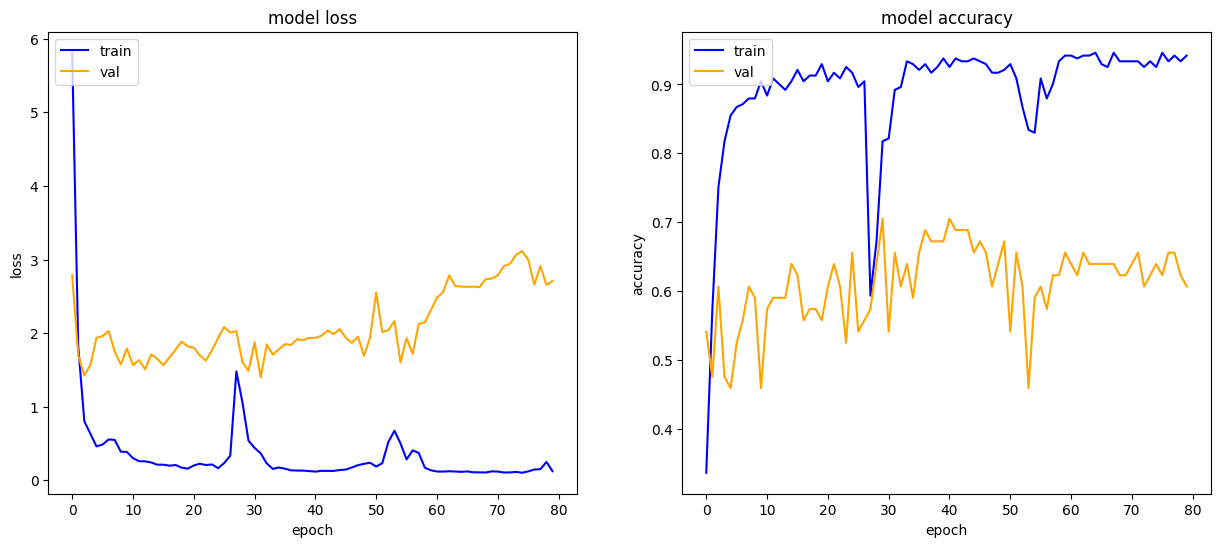

In [11]:
# Graph the training and validation loss and accuracy across epochs
fig, ax = plt.subplots(1, 2, figsize = (15, 6))
metrics = ['loss', 'accuracy']

for a, metric in list(zip(ax, metrics)):
    a.plot(model.history.history[metric], color = 'blue')
    a.plot(model.history.history[f'val_{metric}'], color = 'orange')
    a.set_title(f'model {metric}')
    a.set_xlabel('epoch')
    a.set_ylabel(metric)
    a.legend(['train', 'val'], loc = 'upper left')

In [4]:
# Select the model at the best epoch based on validation accuracy
best_epoch = np.argmax(model.history.history['val_accuracy']) + 1
print(f'Best epoch by validation accuracy: {best_epoch}')

# Load the model saved at that epoch
best_model = tf.keras.models.load_model(os.path.join(checkpoint_dir, f'best_model-epoch_{best_epoch:02d}.h5'))
best_model.summary()

Best epoch by validation accuracy: 30
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embedded_text_input (Input  [(None, 48)]                 0         []                            
 Layer)                                                                                           
                                                                                                  
 dense (Dense)               (None, 256)                  12544     ['embedded_text_input[0][0]'] 
                                                                                                  
 dense_1 (Dense)             (None, 128)                  32896     ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 128)                

In [5]:
# Define save directory and save model
model_dir = './saved_model'
os.makedirs(model_dir, exist_ok = True)
model_path = os.path.join(model_dir, 'model.keras')
best_model.save(model_path)

# Productionize Model to HuggingFace

## Create Repository on HuggingFace

In [7]:
# Import HuggingFace token from local file to grant access
from api_keys import hf_token

# Define user name, repo name, and repo id
hf_username = 'joshua-gottlieb'
repo_name = 'tensorflow-credibility_predictor-v1'
repo_id = f'{hf_username}/{repo_name}'

api = HfApi()

# Create the repository
api.create_repo(repo_id = repo_id, token = hf_token, exist_ok = True)

print(f'Repository created: https://huggingface.co/{repo_id}')

Repository created: https://huggingface.co/joshua-gottlieb/tensorflow-credibility_predictor-v1


## Push Artifacts to HuggingFace

In [12]:
# Define model path to push to HuggingFace from model saved earlier in notebook
model_dir = './saved_model'
model_path = os.path.join(model_dir, 'model.keras')

# Save the tokenizer as a pickle file
tokenizer_path = os.path.join(model_dir, 'tokenizer.pkl')
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)

api.upload_file(path_or_fileobj = model_path, path_in_repo = 'model.keras',
                repo_id = repo_id, token = hf_token)
api.upload_file(path_or_fileobj = tokenizer_path, path_in_repo = 'tokenizer.pkl',
                repo_id = repo_id, token = hf_token)

print(f'Model and tokenizer successfully pushed to: https://huggingface.co/{repo_id}')

No files have been modified since last commit. Skipping to prevent empty commit.


tokenizer.pkl:   0%|          | 0.00/91.4M [00:00<?, ?B/s]

Model and tokenizer successfully pushed to: https://huggingface.co/joshua-gottlieb/tensorflow-credibility_predictor-v1


## Download Model and Tokenizer Artifacts from HuggingFace

In [13]:
# Define repo ID
repo_id = 'joshua-gottlieb/tensorflow-credibility_predictor-v1'

# Define tokenizer and model filenames
tokenizer_filename = 'tokenizer.pkl' # Ensure this matches what was uploaded
model_filename = 'model.keras' # Ensure this matches what was uploaded

# Download the model and tokenizer
tokenizer_path = hf_hub_download(repo_id = repo_id, filename = tokenizer_filename, token = hf_token)
model_path = hf_hub_download(repo_id = repo_id, filename = model_filename, token = hf_token)

# Load the Keras model and unpickle the tokenizer
with open(tokenizer_path, 'rb') as f:
    tokenizer = pickle.load(f)
new_model = tf.keras.models.load_model(model_path)

print('Model and tokenizer loaded successfully!')

tokenizer.pkl:   0%|          | 0.00/91.4M [00:00<?, ?B/s]

Model and tokenizer loaded successfully!


In [14]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embedded_text_input (Input  [(None, 48)]                 0         []                            
 Layer)                                                                                           
                                                                                                  
 dense (Dense)               (None, 256)                  12544     ['embedded_text_input[0][0]'] 
                                                                                                  
 dense_1 (Dense)             (None, 128)                  32896     ['dense[0][0]']               
                                                                                                  
 dense_2 (Dense)             (None, 128)                  16512     ['dense_1[0][0]']         

# Local Inference

In [15]:
# Define repo details
repo_id = 'joshua-gottlieb/tensorflow-credibility_predictor-v1'

# Define tokenizer and model filenames
tokenizer_filename = 'tokenizer.pkl' # Ensure this matches what was uploaded
model_filename = 'model.keras' # Ensure this matches what was uploaded

# Download the model and tokenizer
tokenizer_path = hf_hub_download(repo_id = repo_id, filename = tokenizer_filename, token = hf_token)
model_path = hf_hub_download(repo_id = repo_id, filename = model_filename, token = hf_token)

# Load the Keras model and unpickle the tokenizer
with open(tokenizer_path, 'rb') as f:
    tokenizer = pickle.load(f)
new_model = tf.keras.models.load_model(model_path)

print('Model and tokenizer loaded successfully!')

# Sample test data
test_texts = [
    'How to improve focus and concentration?',
    'What are the side effects of lack of sleep?',
]

# Preprocess test data using the loaded tokenizer
cleaned_test_texts = [re.sub('\s+', ' ', re.sub('[^\w\s]', ' ', p)).strip().lower() for p in test_texts]
X_text_test = np.array([tokenizer.encode(p, precision = 'binary') for p in cleaned_test_texts])

# Dummy numeric input (func_rating)
raw_func_test = np.array([5, 4]).reshape(-1, 1)
X_func_test = tf.keras.utils.to_categorical(raw_func_test, 6)

# Make predictions
predictions = new_model.predict({'embedded_text_input': X_text_test, 'func_rating_input': X_func_test})

# Display results
for i, text in enumerate(test_texts):
    print(f'Prompt: {text}')
    # Select the index with the highest predicted probability, corresponding to human score
    print(f'Predicted Rating: {np.argmax(predictions[i])}')
    print('-' * 50)

Model and tokenizer loaded successfully!
1/1 [==============================] - 0s 91ms/step
Prompt: How to improve focus and concentration?
Predicted Rating: 3
--------------------------------------------------
Prompt: What are the side effects of lack of sleep?
Predicted Rating: 4
--------------------------------------------------
